In [1]:
from IPython.display import display, SVG

In [14]:
import re
import xml.etree.ElementTree as ET
from io import BytesIO
from itertools import product

import vtracer
from PIL import Image

import io

import cairosvg
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
from skimage.metrics import structural_similarity as ssim


def compute_ssim_images(img1: Image.Image, img2: Image.Image, size=(384, 384)):
    """
    Compare two PIL images after resizing to a fixed size using SSIM.

    Parameters:
        img1 (PIL.Image.Image): The first image.
        img2 (PIL.Image.Image): The second image.
        size (tuple): Resize dimensions (default: 384x384).

    Returns:
        score (float): SSIM score.
    """
    # Resize and convert to grayscale
    img1_gray = img1.resize(size, Image.Resampling.LANCZOS).convert("L")
    img2_gray = img2.resize(size, Image.Resampling.LANCZOS).convert("L")
           
    # Convert to numpy arrays
    arr1 = np.array(img1_gray)
    arr2 = np.array(img2_gray)

    # Calculate SSIM
    score_ssim, _ = ssim(arr1, arr2, full=True)

    return score_ssim


def resize_image(image, size: tuple[int, int] = (384, 384)) -> Image.Image:
    """
    Resize a PIL image to the specified size using LANCZOS resampling.

    Parameters:
        image (PIL.Image.Image): The image to resize.
        size (tuple): The target size (width, height).

    Returns:
        PIL.Image.Image: The resized image.
    """
    resized_image = image.resize(size, Image.Resampling.LANCZOS)
    return resized_image

def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
         The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
         The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
         The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if "viewBox" not in svg_code:
        svg_code = svg_code.replace("<svg", f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode("utf-8"))
    return Image.open(io.BytesIO(png_data)).convert("RGB").resize(size)


class VtracerConverter():
    """
    A converter class that transforms raster images into optimized SVG vector graphics
    using vtracer with hyperparameter search and postprocessing.

    Attributes:
        default_svg (str): Fallback SVG content if conversion fails.
        max_size (int): Maximum allowed size (in bytes) for output SVG.
        speckle_values (list[int]): List of speckle filter values to sweep.
        layer_diff_values (list[int]): List of layer difference values to sweep.
        color_precision_values (list[int]): List of color precision values to sweep.
    """

    def __init__(self):
        """
        Initialize the converter with optional maximum SVG size.

        Args:
            max_size (int): Maximum allowed size for output SVG in bytes.
        """
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.speckle_values = [10, 20, 40]
        self.layer_diff_values = [64, 128]
        self.color_precision_values = [4, 5, 6]

    def _postprocess_svg(self, svg_code: str) -> str:
        """
        Post-process the SVG string by removing unnecessary metadata.

        Operations include:
            - Removing the XML declaration line.
            - Removing the `version` attribute from the root <svg> tag.

        Args:
            svg_code (str): Raw SVG string generated by vtracer.

        Returns:
            str: Cleaned and minified SVG string.
        """
        ET.register_namespace("", "http://www.w3.org/2000/svg")
        tree = ET.ElementTree(ET.fromstring(svg_code))
        root = tree.getroot()

        if "version" in root.attrib:
            del root.attrib["version"]

        output = BytesIO()
        tree.write(output, encoding="utf-8", xml_declaration=True)
        result_svg = output.getvalue().decode("utf-8")

        result_svg = re.sub(r"<\?xml[^>]+\?>\s*", "", result_svg)

        return result_svg

    def _convert_image_to_svg(self, image: Image.Image, max_size: int = 10000) -> str:
        """
        Convert a single image to an SVG string by running vtracer with
        multiple hyperparameter combinations and selecting the best result
        based on SSIM similarity and file size constraints.

        Args:
            image (Image.Image): Input PIL image to be vectorized.

        Returns:
            str: Best matching SVG string after conversion and postprocessing.
        """
        best_ssim = -1
        best_svg = self.default_svg
        best_size = 0

        img_rgba = image.convert("RGBA")
        resized_img = resize_image(image=img_rgba, size=(384, 384))
        pixels = list(resized_img.getdata())

        for filter_speckle, layer_difference, color_precision in product(self.speckle_values, self.layer_diff_values, self.color_precision_values):
            svg_str = vtracer.convert_pixels_to_svg(
                rgba_pixels=pixels,
                size=resized_img.size,
                colormode="color",
                hierarchical="stacked",
                mode="polygon",
                filter_speckle=filter_speckle,
                color_precision=color_precision,
                layer_difference=layer_difference,
                corner_threshold=60,
                length_threshold=4.0,
                max_iterations=10,
                splice_threshold=45,
                path_precision=8,
            )

            ssim_score = compute_ssim_images(
                svg_to_png(svg_code=svg_str), image)

            byte_len = len(svg_str.encode("utf-8"))
            display(SVG(svg_str))
            print(f"filter_speckle: {filter_speckle}")
            print(f"color_precision: {color_precision}")
            print(f"layer_difference: {layer_difference}")
            print(len(svg_str.encode("utf-8")))
            print("----------------------------------------")

            if byte_len <= max_size and byte_len > best_size:
                if best_ssim <= ssim_score:
                    best_ssim = ssim_score
                    best_svg = self._postprocess_svg(svg_str)
                    best_size = byte_len

        return best_svg


    def process(self, images: list[Image.Image], max_size: int = 10000) -> list[str]:
        """
        Convert a list of PIL images to their corresponding optimized SVG strings.

        Args:
            images (list[Image.Image]): List of images to convert.

        Returns:
            list[str]: List of SVG strings corresponding to each input image.
        """
        result = []
        for image in images:
            output = self._convert_image_to_svg(image, max_size)
            result.append(output)

        return result


In [15]:
convertor = VtracerConverter()

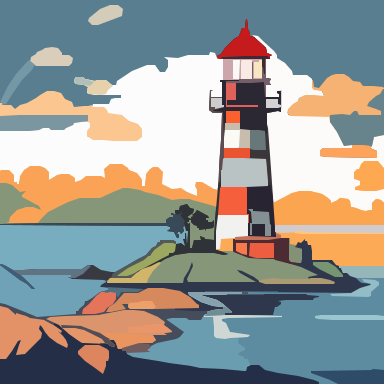

filter_speckle: 10
color_precision: 4
layer_difference: 64
22851
----------------------------------------


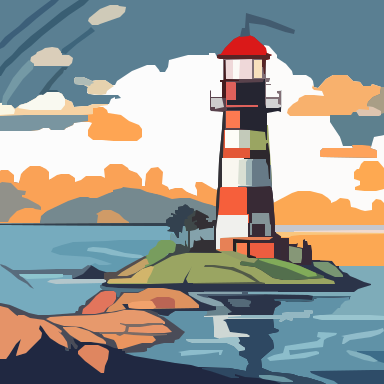

filter_speckle: 10
color_precision: 5
layer_difference: 64
28633
----------------------------------------


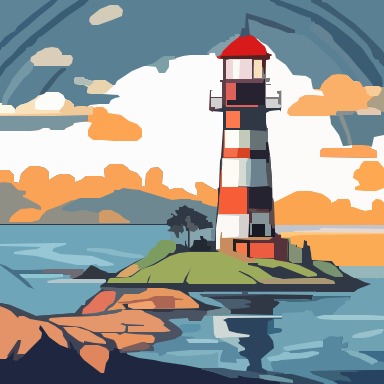

filter_speckle: 10
color_precision: 6
layer_difference: 64
31216
----------------------------------------


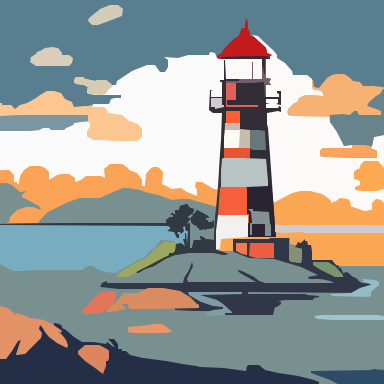

filter_speckle: 10
color_precision: 4
layer_difference: 128
15025
----------------------------------------


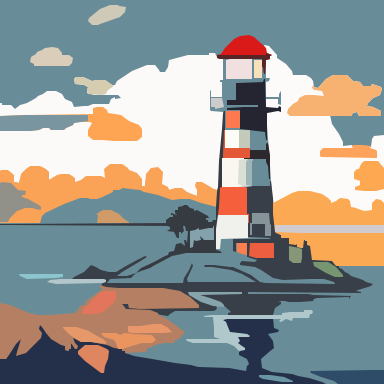

filter_speckle: 10
color_precision: 5
layer_difference: 128
12649
----------------------------------------


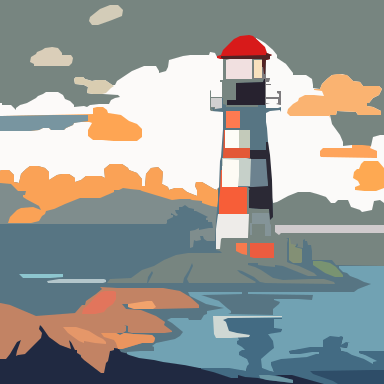

filter_speckle: 10
color_precision: 6
layer_difference: 128
13954
----------------------------------------


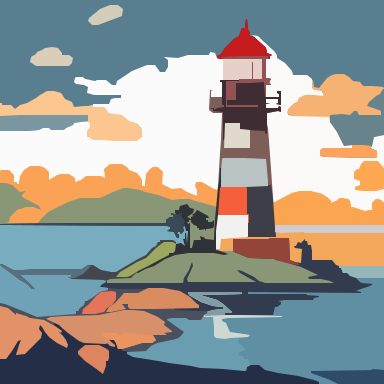

filter_speckle: 20
color_precision: 4
layer_difference: 64
18424
----------------------------------------


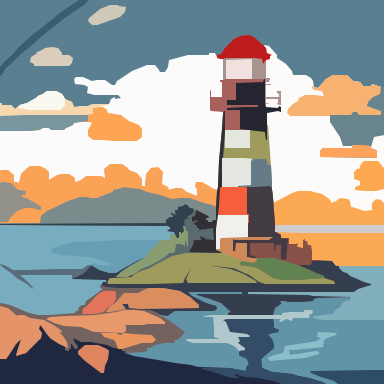

filter_speckle: 20
color_precision: 5
layer_difference: 64
20678
----------------------------------------


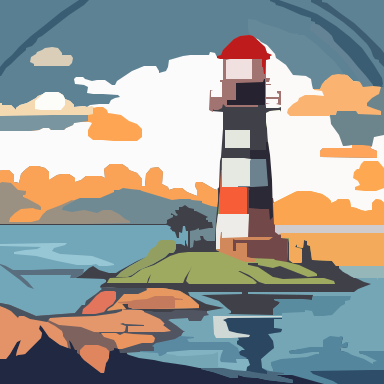

filter_speckle: 20
color_precision: 6
layer_difference: 64
21562
----------------------------------------


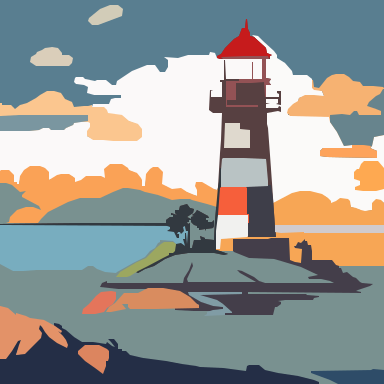

filter_speckle: 20
color_precision: 4
layer_difference: 128
13137
----------------------------------------


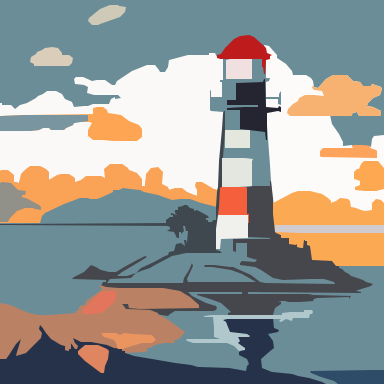

filter_speckle: 20
color_precision: 5
layer_difference: 128
10038
----------------------------------------


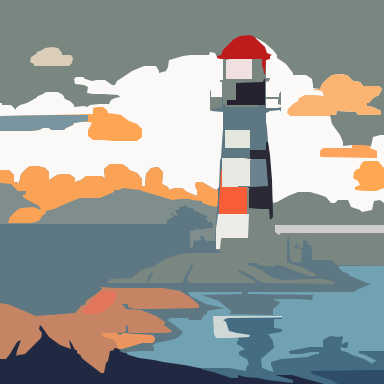

filter_speckle: 20
color_precision: 6
layer_difference: 128
11613
----------------------------------------


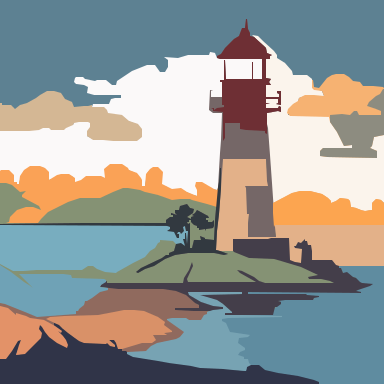

filter_speckle: 40
color_precision: 4
layer_difference: 64
13839
----------------------------------------


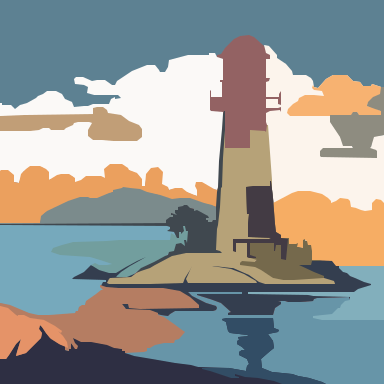

filter_speckle: 40
color_precision: 5
layer_difference: 64
14480
----------------------------------------


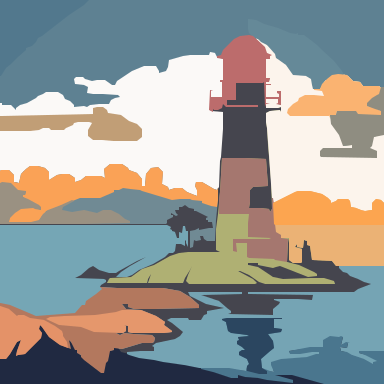

filter_speckle: 40
color_precision: 6
layer_difference: 64
14886
----------------------------------------


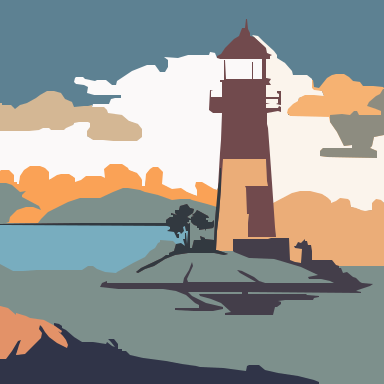

filter_speckle: 40
color_precision: 4
layer_difference: 128
10250
----------------------------------------


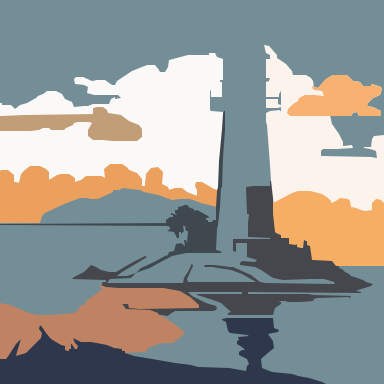

filter_speckle: 40
color_precision: 5
layer_difference: 128
7146
----------------------------------------


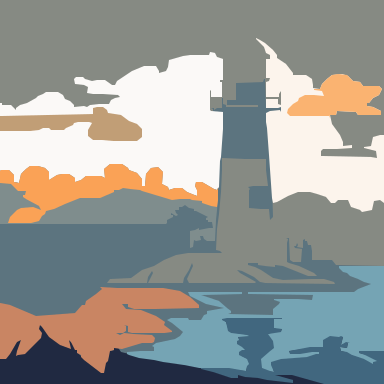

filter_speckle: 40
color_precision: 6
layer_difference: 128
9217
----------------------------------------


In [16]:
image = Image.open("/home/anhndt/pysvgenius/data/test/raw_image.png").convert("RGB")
svg = convertor.process([image], 10000)